# Turkish Delight Airlines Aircraft Analysis

## Business Understanding

"Turkish Delight Airlines," is expanding into the aviation industry with the goal of operating both commercial and private aircraft, primarily focusing on routes between Turkey and the USA. The company’s leadership is unfamiliar with the risks associated with aircraft operations and is seeking data-driven insights to make informed decisions on which aircraft models to purchase for safe and efficient operations.

## Data Understanding

In [1]:
# Import the required libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from datetime import datetime
from ydata_profiling import ProfileReport, profile_report
from project_functions.functions import transform_location
from project_functions.functions import replace_missing_values
from plotnine import *
import pytimetk as tk
from plydata.cat_tools import *


In [3]:
# Read the data
aviation_data = pd.read_csv("data/AviationData.csv", encoding='latin1')
aviation_data.shape

(88889, 31)

In [4]:
# Create a Profile Report
profile = ProfileReport(df=aviation_data)
profile.to_file("profile_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
# Drop the columns 
columns_to_drop = [
    'Latitude','Longitude',
    'Airport.Code','Airport.Name',
    'FAR.Description',
    'Schedule', 
    'Air.carrier', 
    'Publication.Date',
    'Accident.Number',
    'Registration.Number',
    'Aircraft.damage'
 ]

aviation_data.drop(columns_to_drop,inplace=True,axis=1)
aviation_data.shape


(88889, 20)

In [6]:
# Update columns names
aviation_data.rename(columns = lambda x : x.replace("."," ").title(),inplace=True)

In [7]:
# Injury Severity and Total Fatal Injuries have same information. Combine them into one
extracted_numbers = aviation_data['Injury Severity'].str.extract(r'\((\d+)\)').astype(float)
aviation_data['Total Fatal Injuries'] = aviation_data['Total Fatal Injuries'].fillna(extracted_numbers[0])
aviation_data['Total Fatal Injuries'] = aviation_data['Total Fatal Injuries'].fillna(0).astype(int)
aviation_data.drop(['Injury Severity'],inplace=True,axis=1)

In [8]:
# Fill missing values with 0 and convert it to type 'int'
columns_to_fill = ['Total Serious Injuries', 'Total Minor Injuries', 'Total Uninjured']
aviation_data[columns_to_fill] = aviation_data[columns_to_fill].fillna(0).astype(int)

In [9]:
# Change the Event Date to datetime
aviation_data['Event Date'] = pd.to_datetime(aviation_data['Event Date'])

In [10]:
# Adjust the value of the Location column
aviation_data['Location'] = aviation_data.apply(transform_location, axis=1)

In [11]:
# Re-format the Country and Location columns
aviation_data['Country'] = aviation_data['Country'].apply(replace_missing_values)
aviation_data['Country'] = aviation_data['Country'].str.title()
aviation_data['Location'] = aviation_data['Location'].apply(replace_missing_values)

In [12]:
# Update state names to full names
state_codes = pd.read_csv("data/USState_Codes.csv")
state_codes_dict = dict(zip(state_codes['Abbreviation'], state_codes['US_State']))

aviation_data['Location'] = aviation_data['Location'].map(state_codes_dict )


In [13]:
# Update the Engine Type and Aircraft Category columns
aviation_data['Engine Type'] = aviation_data['Engine Type'].apply(replace_missing_values)
aviation_data['Aircraft Category'] = aviation_data.apply(
    lambda row: row['Engine Type'] if pd.isna(row['Aircraft Category']) and row['Engine Type'] in ['Turbo Fan', 'Geared Turbofan'] else row['Aircraft Category'],
    axis=1
)


In [14]:
aviation_data['Aircraft Category'] = aviation_data['Aircraft Category'].replace('Turbo Fan', 'Airplane')
aviation_data = aviation_data[aviation_data['Aircraft Category'] == 'Airplane']

In [15]:
aviation_data.drop(['Engine Type'],inplace=True,axis=1)


In [24]:
aviation_data['Number Of Engines'] = aviation_data['Number Of Engines'].apply(replace_missing_values)
filtered_data = aviation_data[aviation_data['Number Of Engines'] != 'Unknown']
filtered_data['Number Of Engines'] = filtered_data['Number Of Engines'].astype(int)
aviation_data = filtered_data

In [30]:
# Format the Make column
aviation_data['Make'] = aviation_data['Make'].str.title()

In [31]:
# Filter the data based on the year (20 years)
max_date = aviation_data['Event Date'].max()
aviation_data = aviation_data[aviation_data['Event Date'] > max_date - pd.DateOffset(years=20)]

In [32]:
# Clean the missing values in Weather Condition and Broad Pahase of Flight columns
aviation_data['Weather Condition'] = aviation_data['Weather Condition'].apply(replace_missing_values)
aviation_data['Broad Phase Of Flight'] = aviation_data['Broad Phase Of Flight'].apply(replace_missing_values)
aviation_data['Purpose Of Flight']= aviation_data['Purpose Of Flight'].apply(replace_missing_values)

In [35]:
# Clean the missing values in Report Status column and save it to a csv file(Prepared for the LLM to create categories)
aviation_data['Report Status'] = aviation_data['Report Status'].apply(replace_missing_values)
aviation_data['Report Status'].to_csv('data/report_status.csv', index=False)

In [36]:
# Retrieve the categories for the cause of accidents
category_df = pd.read_csv('data/categorized_accident_reasons_llm.csv')
category_df

,Report Status,Category
0,Probable Cause,Pilot Error
1,Probable Cause,Pilot Error
2,Probable Cause,Pilot Error
3,Probable Cause,Pilot Error
4,Probable Cause,Pilot Error
...,...,...
21668,Unknown,Other
21669,Unknown,Other
21670,Unknown,Other
21671,Unknown,Other


In [37]:
# Merge the category_df and aviation_data
aviation_data['temp_index'] = range(len(aviation_data))
category_df['temp_index'] = range(len(category_df))
merged_df = aviation_data.merge(category_df, on='temp_index', suffixes=('', '_category'))
merged_df



,Event Id,Investigation Type,Event Date,Location,Country,Aircraft Category,Make,Model,Amateur Built,Number Of Engines,...,Total Fatal Injuries,Total Serious Injuries,Total Minor Injuries,Total Uninjured,Weather Condition,Broad Phase Of Flight,Report Status,temp_index,Report Status_category,Category
0,20030115X00070,Incident,2003-01-04,Colorado,United States,Airplane,Hawker Siddeley,HS-125-700A,No,2,...,0,0,0,6,VMC,Standing,Probable Cause,0,Probable Cause,Pilot Error
1,20030109X00039,Accident,2003-01-06,Ohio,United States,Airplane,Embraer,ERJ-145LR,No,2,...,0,0,0,50,IMC,Landing,Probable Cause,1,Probable Cause,Pilot Error
2,20030109X00041,Accident,2003-01-08,Texas,United States,Airplane,Carlisle,Comp Air 6,Yes,1,...,0,0,0,1,VMC,Cruise,Probable Cause,2,Probable Cause,Pilot Error
3,20030115X00066,Accident,2003-01-11,Florida,United States,Airplane,Cessna,150K,No,1,...,0,1,1,0,VMC,Landing,Probable Cause,3,Probable Cause,Pilot Error
4,20030325X00388,Incident,2003-01-11,Hawaii,United States,Airplane,Boeing,717-200,No,2,...,0,0,0,87,VMC,Climb,Probable Cause,4,Probable Cause,Pilot Error
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21668,20221213106455,Accident,2022-12-13,Montana,United States,Airplane,Piper,PA42,No,2,...,0,0,0,1,Unknown,Unknown,Unknown,21668,Unknown,Other
21669,20221215106463,Accident,2022-12-14,Puerto Rico,United States,Airplane,Cirrus Design Corp,SR22,No,1,...,0,0,0,1,VMC,Unknown,Unknown,21669,Unknown,Other
21670,20221219106475,Accident,2022-12-15,Kansas,United States,Airplane,Swearingen,SA226TC,No,2,...,0,0,0,1,Unknown,Unknown,Unknown,21670,Unknown,Other
21671,20221219106470,Accident,2022-12-16,Florida,United States,Airplane,Cessna,R172K,No,1,...,0,1,0,0,VMC,Unknown,Unknown,21671,Unknown,Other


In [38]:
merged_df['Category'] = merged_df.apply(
    lambda row: row['Report Status_category'] if row['Report Status_category'] == 'Probable Cause' else row['Category'],
    axis=1
)
merged_df.head()

,Event Id,Investigation Type,Event Date,Location,Country,Aircraft Category,Make,Model,Amateur Built,Number Of Engines,...,Total Fatal Injuries,Total Serious Injuries,Total Minor Injuries,Total Uninjured,Weather Condition,Broad Phase Of Flight,Report Status,temp_index,Report Status_category,Category
0,20030115X00070,Incident,2003-01-04,Colorado,United States,Airplane,Hawker Siddeley,HS-125-700A,No,2,...,0,0,0,6,VMC,Standing,Probable Cause,0,Probable Cause,Probable Cause
1,20030109X00039,Accident,2003-01-06,Ohio,United States,Airplane,Embraer,ERJ-145LR,No,2,...,0,0,0,50,IMC,Landing,Probable Cause,1,Probable Cause,Probable Cause
2,20030109X00041,Accident,2003-01-08,Texas,United States,Airplane,Carlisle,Comp Air 6,Yes,1,...,0,0,0,1,VMC,Cruise,Probable Cause,2,Probable Cause,Probable Cause
3,20030115X00066,Accident,2003-01-11,Florida,United States,Airplane,Cessna,150K,No,1,...,0,1,1,0,VMC,Landing,Probable Cause,3,Probable Cause,Probable Cause
4,20030325X00388,Incident,2003-01-11,Hawaii,United States,Airplane,Boeing,717-200,No,2,...,0,0,0,87,VMC,Climb,Probable Cause,4,Probable Cause,Probable Cause


In [39]:
aviation_data = merged_df.drop(columns=['Report Status_category', 'temp_index'])

In [41]:
aviation_data['Category'] = aviation_data['Category'].apply(replace_missing_values)

In [42]:

aviation_data.drop('Event Id', axis=1, inplace=True)

In [43]:
aviation_data.to_csv('data/aviation_data_cleaned.csv', index=False)

## Exploratory Data Analysis

### Cause of the accidents

Pilot Error: The leading cause of accidents across various aircraft models, notably affecting Cessna, Beech, and Piper. Pilot error has a high occurrence rate, with models like Cessna and Beech experiencing over 200 incidents attributed to pilot mistakes. This suggests that pilot training and operational procedures need to be a focal point for Turkish Delight Airlines, particularly when choosing aircraft types that have a higher susceptibility to human error.

Mechanical Failures: Boeing and Bombardier show notable mechanical failure rates. Boeing, a significant player in long-distance international routes (such as those between Turkey and the USA), has recorded both substantial mechanical failures and probable causes. Mechanical reliability will be critical in selecting aircraft for long-haul flights, as disruptions on such routes could be costly and dangerous. Focusing on models with a lower percentage of mechanical issues, like the Bombardier Inc. series, may contribute to safer operations.

Weather-related Incidents: While less frequent than pilot error and mechanical failure, weather conditions remain a concern, especially for models like Boeing, which saw a higher count of weather-related issues. This could be important when planning routes between Turkey and the USA, as weather patterns could impact long-haul flights. Investing in aircraft with advanced weather-related safety systems or route planning technologies can reduce these risks.



In [2]:
aviation_data = pd.read_csv('data/aviation_data_cleaned.csv')

In [3]:
# change all nan values in the Category column to 'Unknown'
aviation_data['Category'] = aviation_data['Category'].fillna('Unknown')

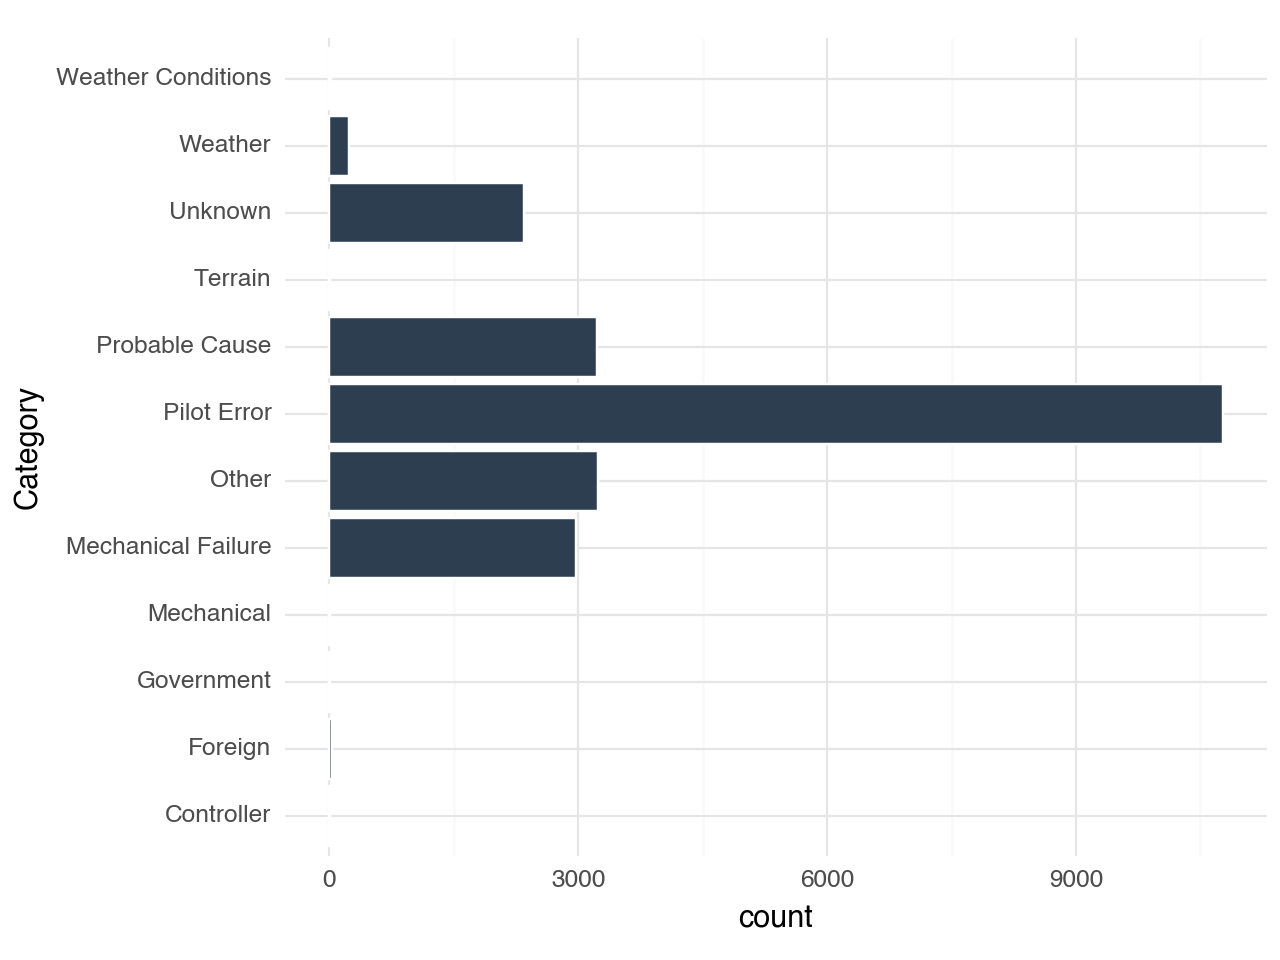

<Figure Size: (640 x 480)>

In [5]:
(ggplot(aviation_data, aes(x='Category')) +
    geom_bar(fill='#2c3e50',color='white') +
    coord_flip() + 
    theme(axis_text_x=element_text(rotation=45, hjust=1)) +\
    theme_minimal()
)

In [88]:
pivot_table = aviation_data.pivot_table(index='Make', columns='Category', aggfunc='size', fill_value=0).sort_values(by='Mechanical Failure', ascending=False)
pivot_table['Percentage of Mechanical Failures'] = pivot_table['Mechanical Failure'] / pivot_table.sum(axis=1) * 100
pivot_table = pivot_table.reset_index()
pivot_table


Category,Make,Controller,Foreign,Government,Mechanical,Mechanical Failure,Other,Pilot Error,Probable Cause,Unknown,Weather,Weather Conditions,Percentage of Mechanical Failures
0,Cessna,0,1,1,0,114,121,226,76,20,7,0,20.141343
1,Beech,0,1,1,0,66,85,232,57,23,7,0,13.983051
2,Boeing,0,6,0,2,66,236,106,110,8,50,1,11.282051
3,Piper,0,0,0,0,58,121,193,58,30,4,0,12.500000
4,Bombardier Inc,0,0,0,0,18,19,18,0,2,5,0,29.032258
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,Hawker Beechcraft,0,0,0,0,0,2,4,0,1,1,0,0.000000
192,Hawker Beech,0,0,0,0,0,1,0,0,0,0,0,0.000000
193,Aerospatiale,0,0,0,0,0,1,0,0,0,0,0,0.000000
194,Gulfstream American Corp,0,1,0,0,0,0,0,0,0,0,0,0.000000


In [77]:
# Data Preparation
pivot_table = pivot_table\
    .melt(
        id_vars='Make', 
        value_vars=['Mechanical Failure', 'Pilot Error', 'Weather Conditions','Probable Cause', 'Other'], 
        var_name='Category', 
        value_name='Count'
        )
    
pivot_table = pivot_table.sort_values(by='Count', ascending=False)
pivot_table





,Make,Category,Count
786,Boeing,Other,236
197,Beech,Pilot Error,232
196,Cessna,Pilot Error,226
199,Piper,Pilot Error,193
787,Piper,Other,121
...,...,...,...
449,American Champion Aircraft,Weather Conditions,0
450,Butler Aircraft Company,Weather Conditions,0
451,Beriev Aircraft Company,Weather Conditions,0
452,Curtiss Wright,Weather Conditions,0


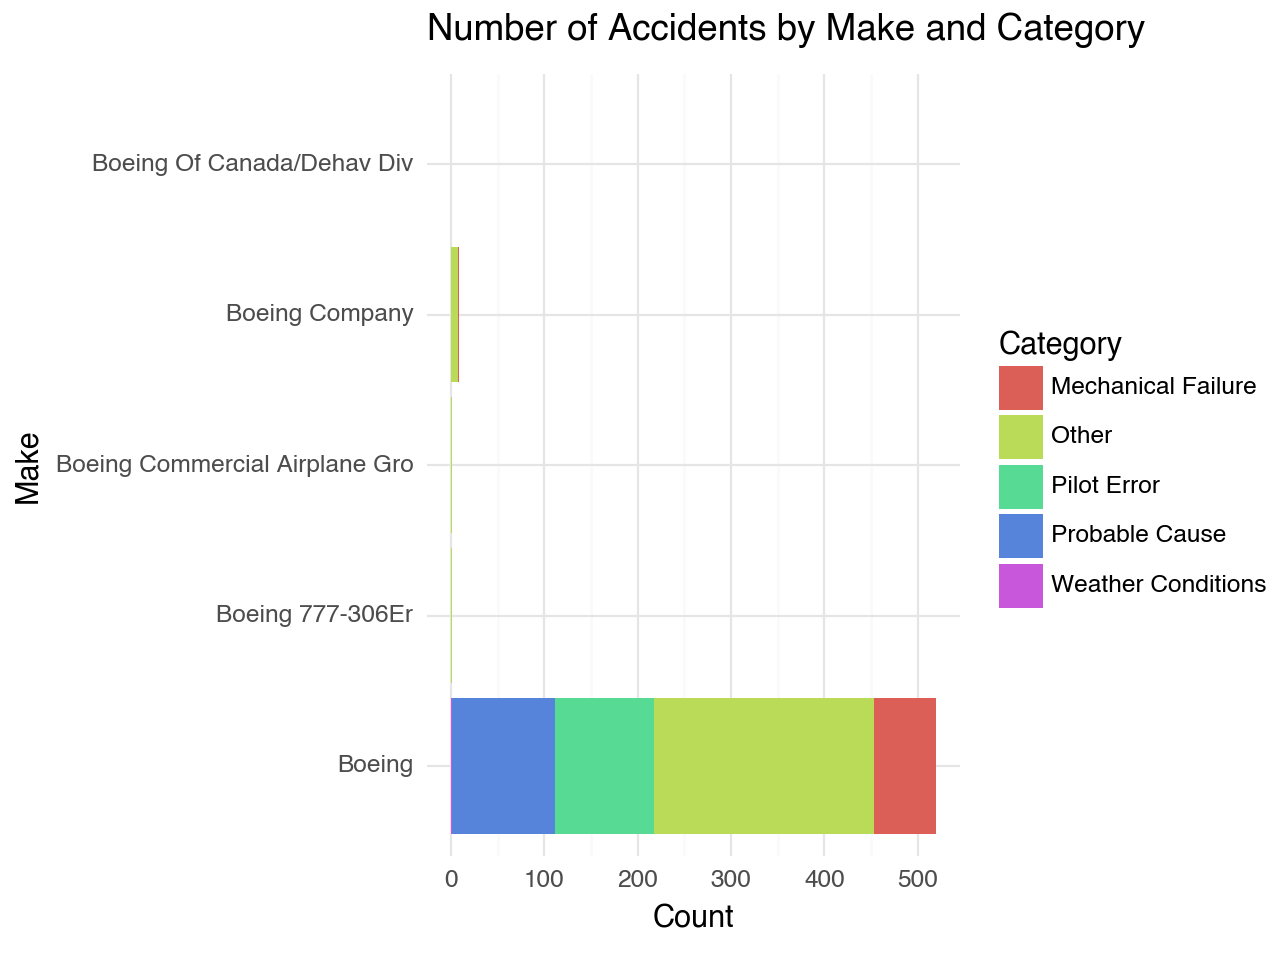

<Figure Size: (640 x 480)>

In [79]:
# Visualization of the data which is Make starts with 'Boeing'
pivot_table = pivot_table[pivot_table['Make'].str.startswith('Boeing')]
(
    ggplot(pivot_table, aes(x='Make', y='Count', fill='Category')) +
    geom_col() +
    coord_flip() + 
    labs(title='Number of Accidents by Make and Category', x='Make', y='Count') +
    theme_minimal()
)

### Number of Engines

Engine Configuration : Most aircraft in the dataset seem to have two engines, which is typical for modern commercial airplanes, balancing efficiency and performance.

Safety and Engines : The data doesn't directly link the number of engines to injury or fatality outcomes in the examples provided. However, multi-engine planes (especially those with more than two engines) are typically designed with redundancy to mitigate engine failure risks. Aircraft with three or more engines may provide an extra layer of safety in case of engine-related issues.

Operational Efficiency: Two-engine aircraft are known for being more fuel-efficient and economical for long-distance routes, which would be ideal for Turkish Delight Airlines' transatlantic operations between Turkey and the USA.

In [23]:
# show the Number of Engines with na values
aviation_data['Number Of Engines'] = aviation_data['Number Of Engines'].apply(replace_missing_values)

In [25]:
# convert the data type of Number Of Engines to int if value is not 'Unknown'
aviation_data['Number Of Engines'] = aviation_data['Number Of Engines'].apply(lambda x: int(x) if x != 'Unknown' else x)

In [115]:
filtered_data = aviation_data[aviation_data['Number Of Engines'] != 'Unknown']

# Convert the 'Number Of Engines' column to integers
filtered_data['Number Of Engines'] = filtered_data['Number Of Engines'].astype(int)

# Filter rows where 'Number Of Engines' is 2,3 or 4
filtered_data = filtered_data[filtered_data['Number Of Engines'].isin([2,3,4])]

aviation_data = filtered_data

pd.DataFrame(aviation_data).to_csv('aviation_data_engine.csv', index=False)


### Create scoring for Injury Categories

Weighted Score: The weighted score system assigns higher importance to fatal injuries, followed by serious injuries and minor injuries. From the data sampled, many incidents have a weighted score of zero, indicating either no injuries or only minor damage.

Injury Distribution: There are incidents with serious consequences, but they appear to be relatively rare in the dataset based on the examples provided. This means that many incidents involve minimal or no injuries at all.

Incident Categories: The most significant incidents with higher weighted scores would likely have involved multiple serious or fatal injuries. Aircraft models like Boeing 757 and Embraer ERJ-145LR, which are featured, could either have a higher capacity, thus contributing to higher potential injury rates in case of accidents, or involve more severe accident types, such as during landing or cruising.



In [93]:
aviation_data['Weighted Score'] = aviation_data['Total Fatal Injuries'] * 5\
+ aviation_data['Total Serious Injuries'] * 3\
+ aviation_data['Total Minor Injuries'] * 2

In [108]:
temp_df = aviation_data.groupby('Make')['Weighted Score'].sum().sort_values(ascending=False).reset_index()
temp_df = temp_df[temp_df['Weighted Score'] != 0]\
            .sort_values(by='Weighted Score', ascending=False)\
            .assign(Make = lambda x : cat_reorder(x['Make'],x['Weighted Score']))

temp_df = temp_df.head(20)

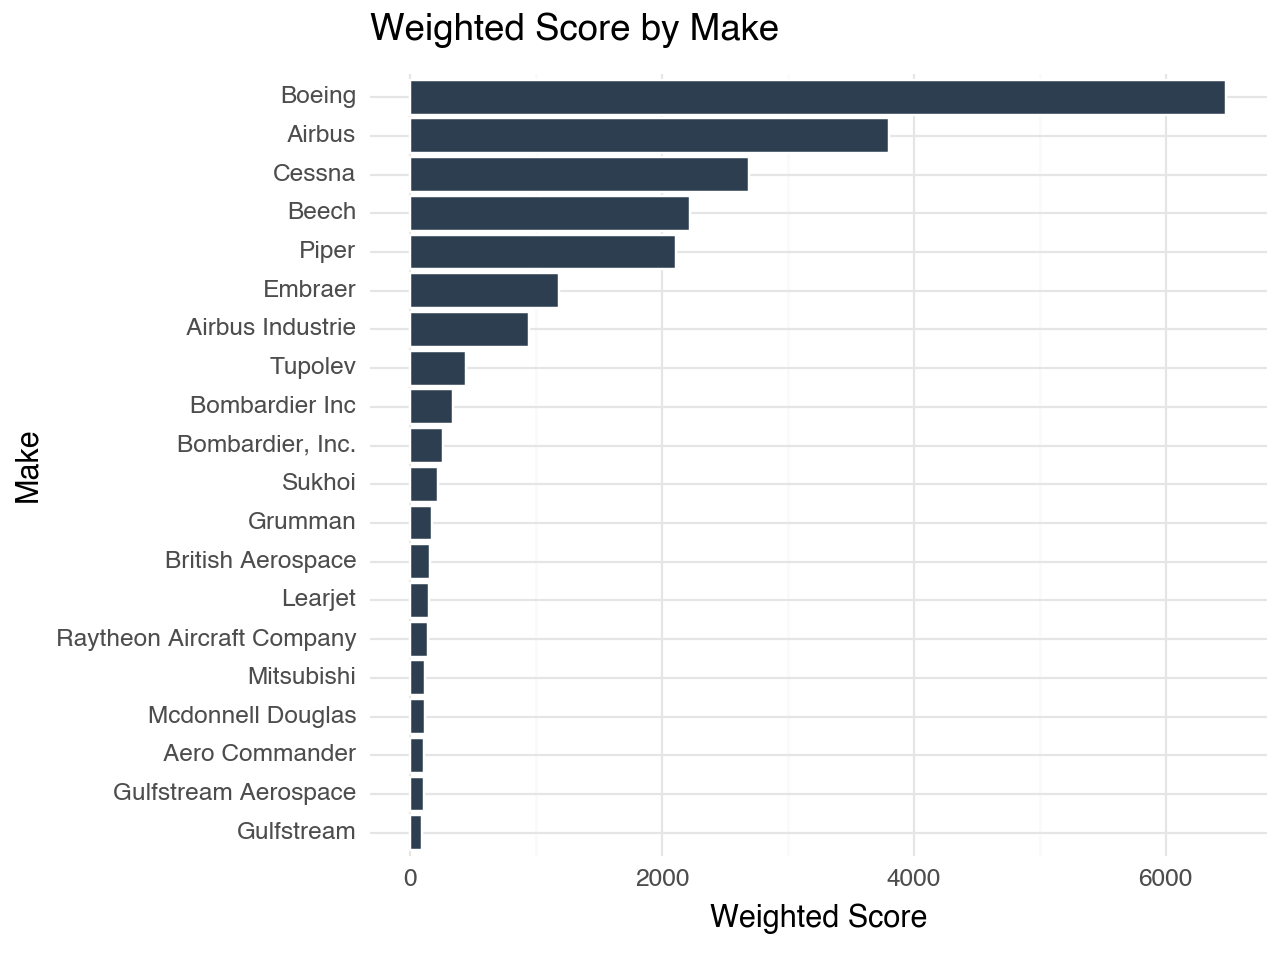

<Figure Size: (640 x 480)>

In [109]:

(
    ggplot(temp_df, aes(x='Make', y='Weighted Score')) +
    geom_col(fill='#2c3e50',color='white') +
    coord_flip() + 
    theme(axis_text_x=element_text(rotation=45, hjust=1)) +
    labs(title='Weighted Score by Make', x='Make', y='Weighted Score') +
    theme_minimal()
)

### Analyse the timeline for the accidents by Manufacturer

Days Since Last Accident: For each aircraft make, the "Days Since Last Accident" column reflects how long it has been since the last incident. In the provided data, Aero Commander has incidents spaced widely apart, ranging from 0 days (indicating back-to-back accidents) to over 10,000 days.

Variability Across Time: The large range in the "Days Since Last Accident" suggests that some aircraft may experience long periods of safe operation, while others face frequent incidents. This could point to either variations in maintenance practices or operational factors influencing safety.


In [52]:
aviation_data_filtered_by_least_risky_injured_score = aviation_data['Make'].isin(temp_df['Make'])

In [53]:
aviation_data['Event Date'] = pd.to_datetime(aviation_data['Event Date'], errors='coerce')


In [54]:
# Calculate the maximum date for each 'Make' and 'Model'
max_date = datetime.today()
date_df = aviation_data.groupby(['Make', 'Model'])['Event Date'].max().sort_values(ascending=False).reset_index()

# Calculate the number of days since the last accident
date_df['Days Since Last Accident'] = (max_date - date_df['Event Date']).dt.days

# Sort the DataFrame by 'Days Since Last Accident' in descending order
date_filtered_df = date_df.sort_values(by='Days Since Last Accident', ascending=False)

# Display the resulting DataFrame
date_filtered_df

,Make,Model,Event Date,Days Since Last Accident
1162,Embraer,ERJ-145LR,2003-01-06,7946
1161,Mcdonnell Douglas,MD-11-C,2003-01-14,7938
1160,Canadair,CRJ-600,2003-02-14,7907
1159,Boeing,DC-9-82,2003-03-14,7879
1158,Boeing,737-924,2003-04-06,7856
...,...,...,...,...
4,Gates Lear Jet Corp.,36,2022-11-30,678
3,Learjet,35,2022-12-01,677
2,Piper,PA-44,2022-12-09,669
1,Piper,PA42,2022-12-13,665


In [55]:
new = date_filtered_df\
    .groupby('Make')\
    .summarize_by_time(
        date_column = 'Event Date',
        value_column = 'Days Since Last Accident',
        freq = 'Y',
        agg_func = 'sum',
        wide_format = False
    )


#df_final = new.sort_values(by='Days Since Last Accident', ascending=False)


In [111]:
df2_final = new
df2_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031 entries, 0 to 1030
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Make                      1031 non-null   object
 1   Event Date                1031 non-null   int32 
 2   Days Since Last Accident  1031 non-null   int64 
dtypes: int32(1), int64(1), object(1)
memory usage: 20.3+ KB


In [113]:
# Ensure 'Event Date' is parsed as datetime
df2_final['Event Date'] = pd.to_datetime(df2_final['Event Date'], errors='coerce')

# Extract the year from 'Event Date'
df2_final['Event Date'] = df2_final['Event Date'].dt.year

df2_final


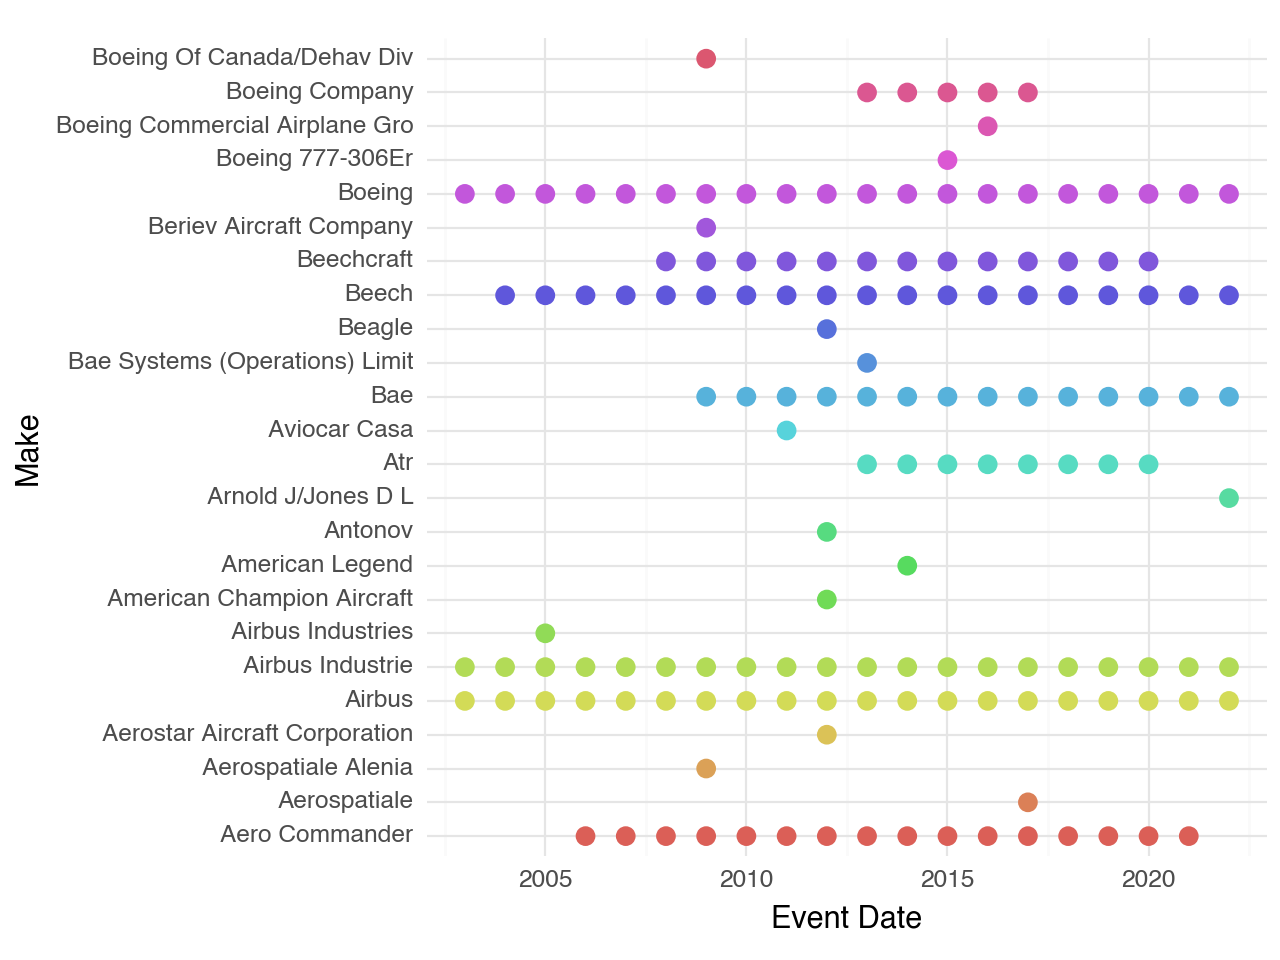

<Figure Size: (640 x 480)>

In [58]:
# Plotting with ggplot
from plotnine import ggplot, aes, geom_point, theme_minimal, theme, element_rect, element_text

ggplot(
    mapping = aes('Event Date', 'Make', color='Make'),
    data = df2_final.head(150)
) + geom_point(size=3) + theme_minimal() + theme(
    strip_background = element_rect(fill = "#2c3e50"),
    strip_text       = element_text(color = "white"),
    legend_position = 'none',
    #figure_size = (12,6),
    subplots_adjust = {'wspace' : 0.25},
    plot_title = element_text(ha='center')
)


## Conclusions




Based on the analysis, here are the recommendations for Turkish Delight Airlines when choosing aircraft models for their operations:

1. Prioritize Safety through Pilot Training and Automation: Focus on aircraft that incorporate advanced automation and safety systems to reduce pilot error, which is the leading cause of accidents. Aircraft with advanced avionics and autopilot features, such as those from Boeing or Airbus, should be prioritized to minimize human error.

2. Select Aircraft with Lower Mechanical Failure Rates: Choose models with a proven record of mechanical reliability, particularly for long-haul flights. Aircraft with higher mechanical failure records should be avoided or used on shorter, less critical routes.

3. Choose Aircraft Equipped for Adverse Weather Conditions:  Consider aircraft models with advanced weather detection and navigation systems. These should be particularly important for routes between Turkey and the USA, where weather can be a factor.

4. Minimize Injury Risk by Selecting Aircraft with Low Injury Rates: Focus on aircraft with historically low injury rates based on the weighted injury score analysis.

5. Use 'Days Since Last Accident' as a Key Metric for Reliability: Prefer aircraft models that show long periods between accidents. Avoid models with frequent accidents or those that have had recent incidents.

6. Number of Engines for Optimal Efficiency and Safety: Two-engine aircraft should be prioritized for long-haul flights between Turkey and the USA. These aircraft are more fuel-efficient and provide sufficient engine redundancy for safe operation.

## Limitations



While the recommendations provide a structured approach to selecting aircraft for Turkish Delight Airlines, there are several limitations to consider in the decision-making process:

1. Historical Bias in Accident Data: The analysis is based on historical accident data, which may not fully reflect the current performance of newer aircraft models or recently improved safety measures.

2. Incomplete Data on Non-Reported Incidents: Not all accidents or incidents may be included in the dataset, particularly for minor incidents or those not officially reported. This can skew the perception of safety and reliability for certain aircraft models.

3. Limited Insights into Maintenance and Operational Practices: The data focuses on the outcomes of accidents (e.g., injuries, causes, days since last accident) but does not account for differences in maintenance practices, operational procedures, or the level of crew training, all of which can significantly influence safety.

4. Variability in Routes and Conditions: Aircraft performance and accident likelihood can vary depending on the routes they operate. Long-haul transatlantic flights between Turkey and the USA might pose different challenges (e.g., weather conditions, airspace regulations) compared to domestic or short-haul operations.

5. Economic and Financial Constraints: Aircraft with better safety and performance records might come with a higher purchase or leasing cost. Similarly, models with advanced safety technology could require significant financial investment in training and maintenance.

6. Regulatory and Certification Requirements: Different aircraft models have varying levels of regulatory requirements for maintenance, safety certifications, and crew training. Some models might require specialized skills or additional resources to meet regulatory standards.

7. Technological Advances: Aircraft models that are historically safer may lack the latest fuel-efficient or environmentally friendly technology. Choosing older models might lead to higher operational costs in the long run, particularly in fuel consumption and emissions.

8. Long-term vs Short-term Focus: Decisions based on current data may not account for future trends, such as evolving safety standards, regulatory changes, or market demand. Aircraft models that are optimal today may not perform as well in the future.


## Next Steps

1. Perform a Detailed Risk Assessment: Conduct a thorough risk assessment that includes an analysis of both historical accident data and predictive models based on current operational conditions, routes, and market demands. Consider the specific risks of operating international flights between Turkey and the USA, such as weather patterns, regulatory differences, and air traffic.
   
2. Integrate Newer Technologies: Evaluate the latest aircraft models that incorporate advanced safety, fuel efficiency, and environmental sustainability features. Invest in modern technology that can provide both short-term safety benefits and long-term operational efficiency. 

3. Pilot Training and Safety Protocols: Develop a comprehensive training program for pilots and crew that emphasizes error prevention, emergency handling, and use of advanced avionics systems. Implement a standardized protocol for responding to mechanical failures and adverse weather conditions.

4. Standardize Maintenance Protocols: Establish rigorous maintenance and inspection schedules based on manufacturer recommendations and regulatory requirements. Use predictive maintenance technologies to identify potential issues before they result in accidents

5. Leverage Data for Continuous Improvement: Implement a robust data analytics platform to track and analyze flight performance, accident reports, and maintenance records in real-time.

